### Импорт библиотек

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as  pd
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from keras.datasets import fashion_mnist
from keras.utils import np_utils
from keras import backend as K
import umap
import os

# Для визуализации
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Using TensorFlow backend.


### Оглавление
### Глава 1.Загрузка и "предобработка" данных
### Глава 2.TSNE для Fasnion MNIST
### Глава 3.Линейные и не очень алгоритмы для Fasnion MNIST
### Глава 4.Umap для Fasnion MNIST
### Глава 5.Восстановление изображения при помощи PCA

### Глава 1.Загрузка и "предобработка" данных
Шаг 1-грузим. Шаг 2-сплитим. Шаг 3-кодируем переменные и делаем отдельный датасет для Umap (потому что я захотел вынести его как отдельный метод впринципе))

In [0]:
from six.moves import urllib
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('Fashion-MNIST', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata(' Fashion-MNIST')

In [0]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [0]:
data = np.array(np.vstack([X_train, X_test]), dtype=np.float64) / 255.0
target = np.hstack([y_train, y_test])
classes = [
    'T-shirt/футболка',
    'Trouser/брюки',
    'Pullover/свитер',
    'Dress/платье',
    'Coat/пальто',
    'Sandal/сандали',
    'Shirt/рубашка',
    'Sneaker/кроссовки',
    'Bag/сумка',
    'Ankle boot/полусапожки']

### Глава 2.TSNE для Fasnion MNIST

In [0]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X_test)

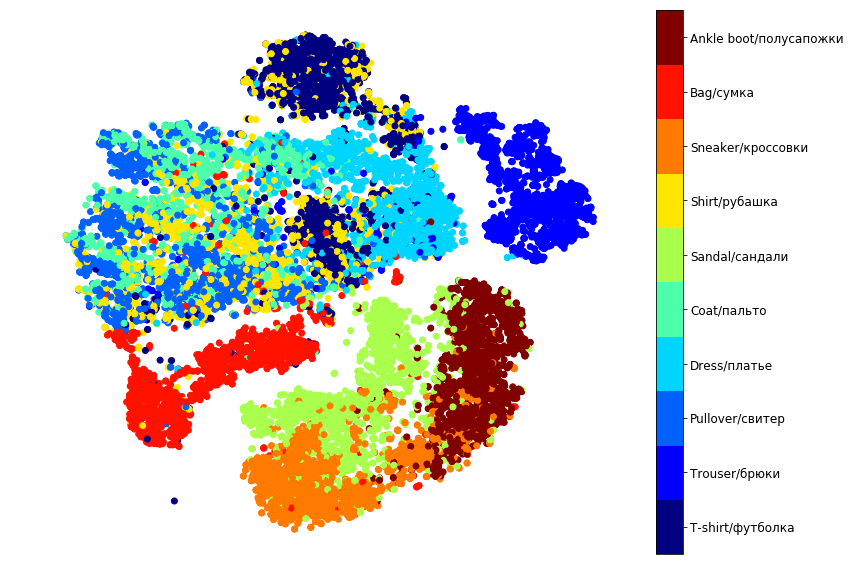

In [0]:

plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_test, cmap="jet")
plt.axis('off')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.show()

Что у нас имеется сказать по данной картине:
1. Обувь закинуло в 1 кластер, но между собой разделено не лучшим образом.
2. Сумки отдельно,не считая пары выбросов.
3. Брюки отдельно.
4. А вот на верхней одежде у нас бардак . Надо покопаться и взглянуть пристальней на пулловер футболки и пальто

Вывод: Алгоритм приемлимо сегментирует одежду по типу( обувь,сумки и.т.п.), но есть таки проблемы внутри кластеров.

In [0]:
idx = (y == 2) | (y == 4) | (y == 6) 
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

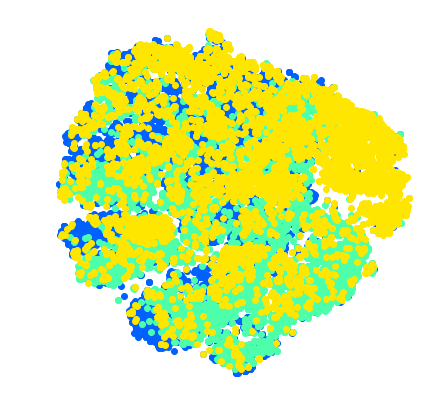

In [0]:
plt.figure(figsize=(7,7))
for digit in (2, 4, 6):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

Вот мы вытянули нашу "верхнюю одежду" в отдельный сабсет, попробуем закинуть меток на весь сет и сабсет

In [0]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_clothes(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

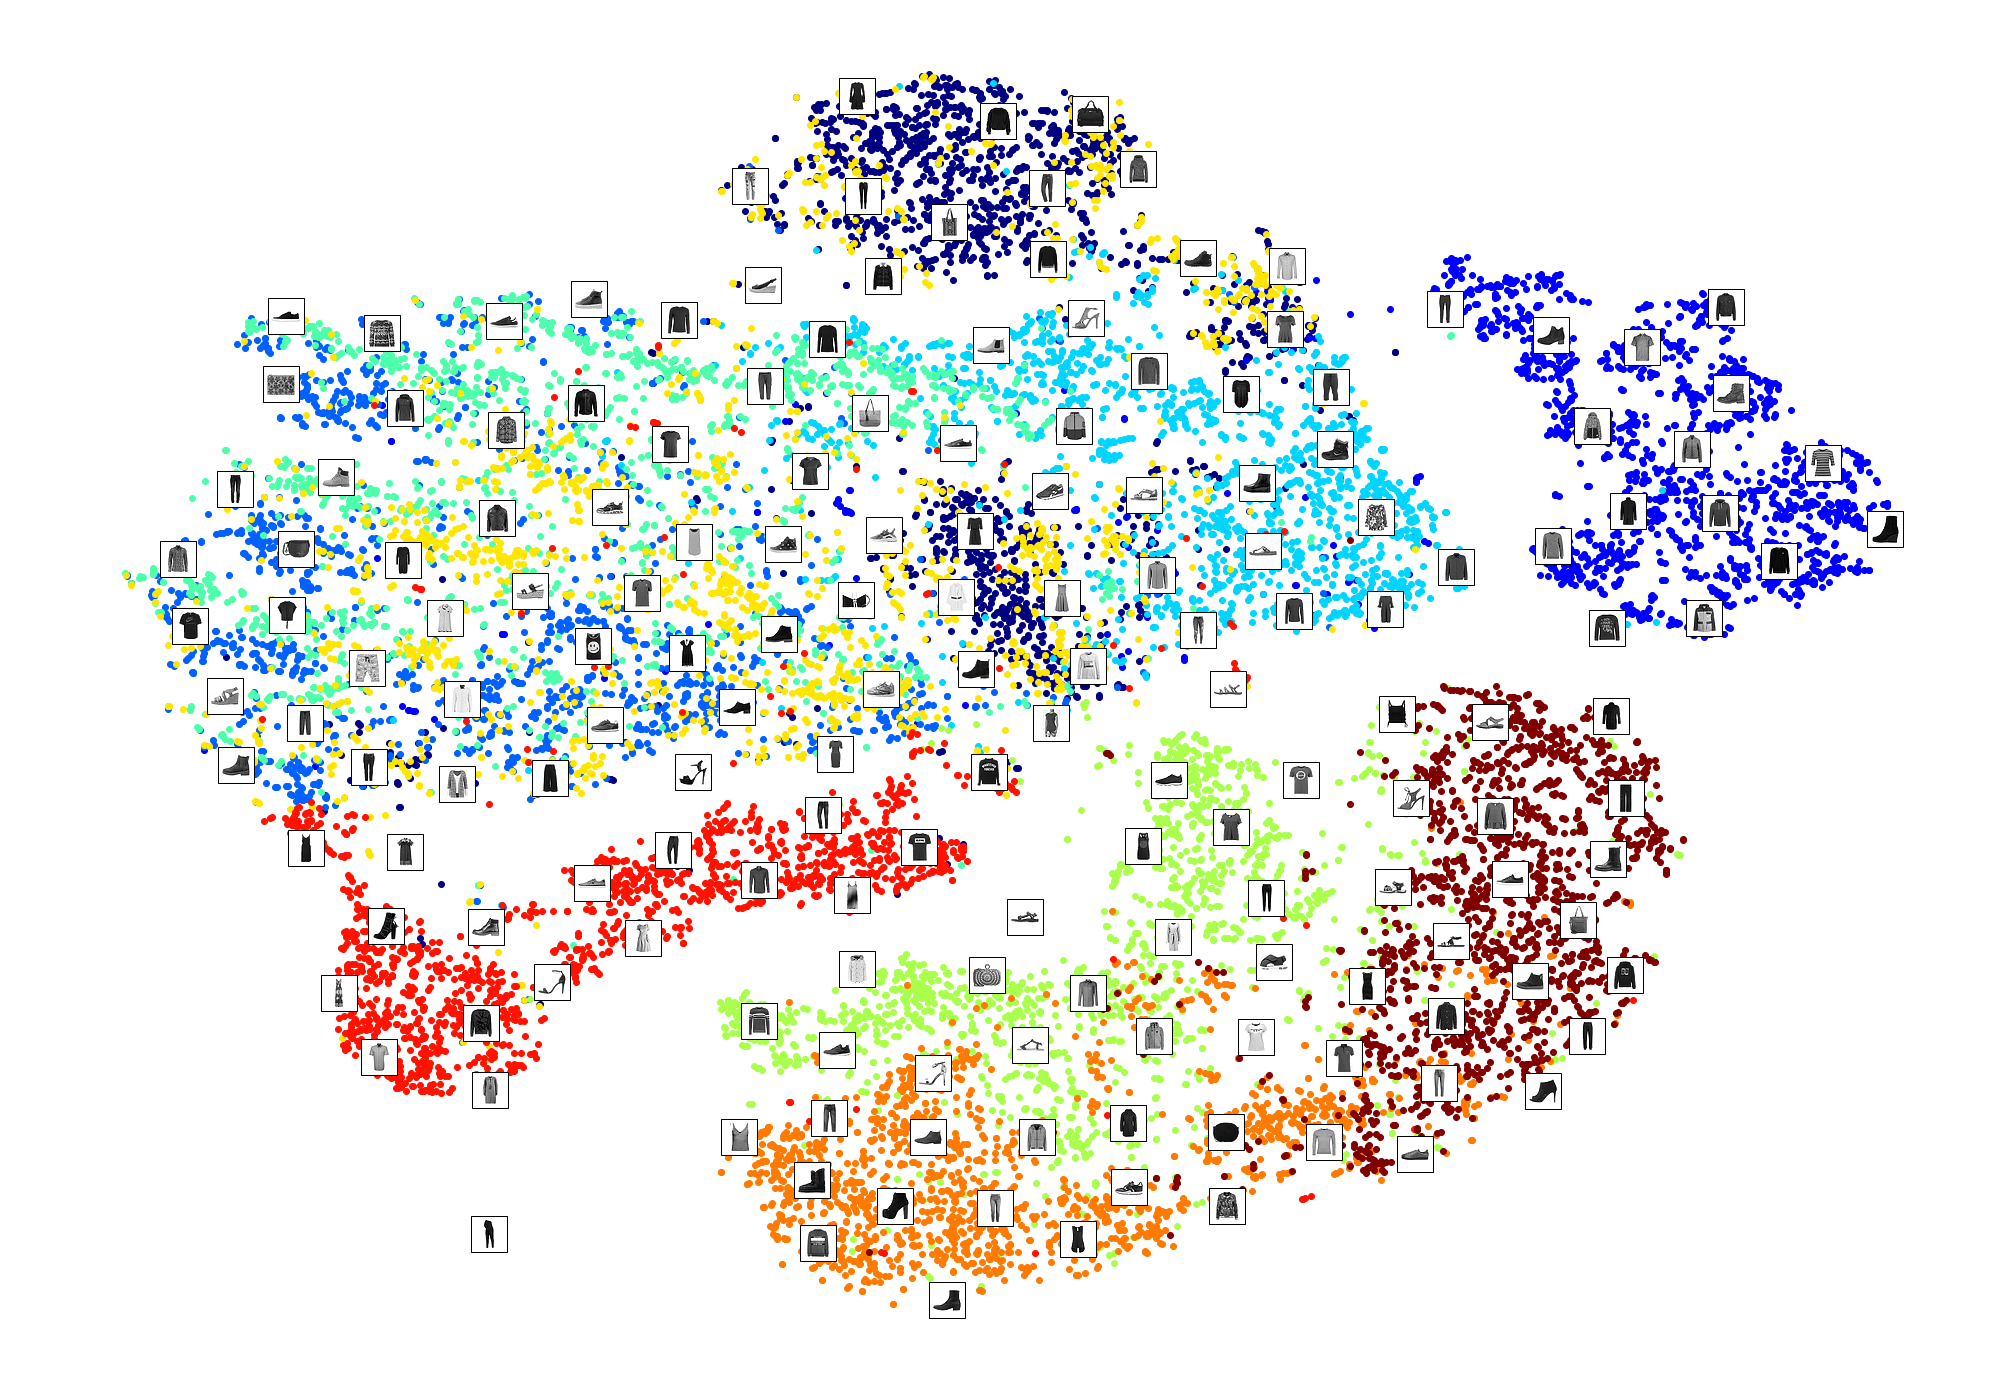

In [0]:
plot_clothes(X_reduced, y_test, images=mnist['data'], figsize=(35, 25))

Положение меток довольно плохо описывает наш сабсет

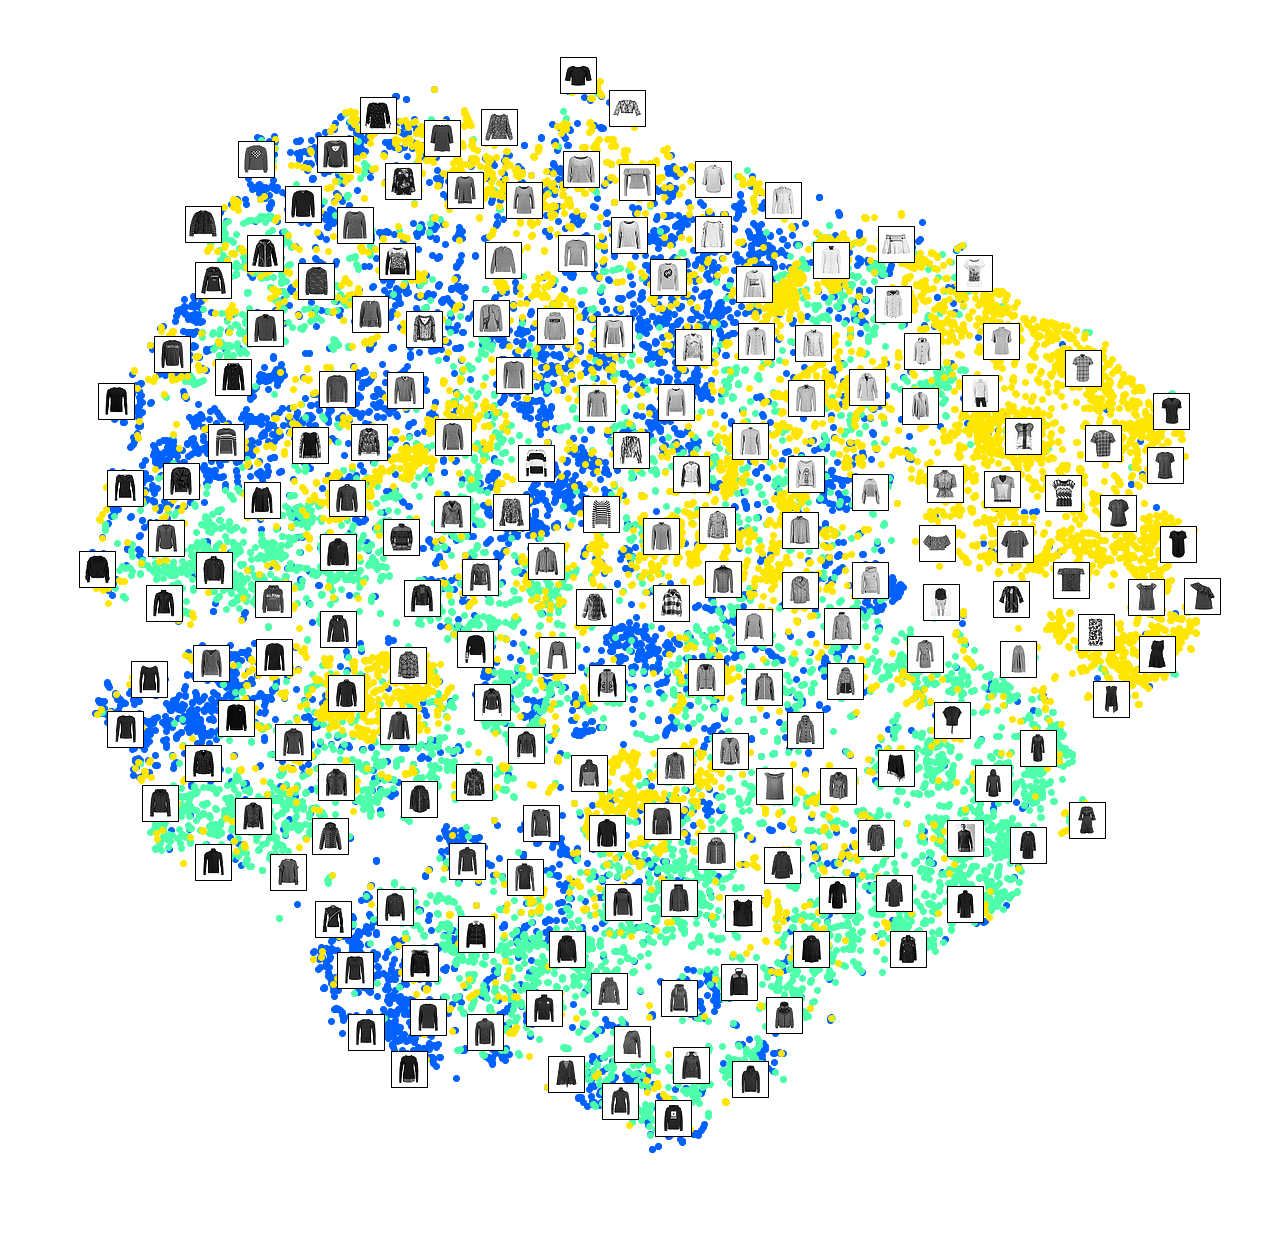

In [0]:
plot_clothes(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

Вроде бы повеселее, по крайней мере все метки характеризуют верхнуюю одежду, НО....
внутри этого "кластера" тяжко отследить логику расположения меток, то есть у нас есть общее представление о данных но конкретизация осавляет желать лучшего.

### Глава 3.Линейные и не очень алгоритмы для Fasnion MNIST

Попробуем линейные методы, их комбинация, посмотрим как друг от друга отличаются.
 -Начнем с PCA


PCA took 1.4s.


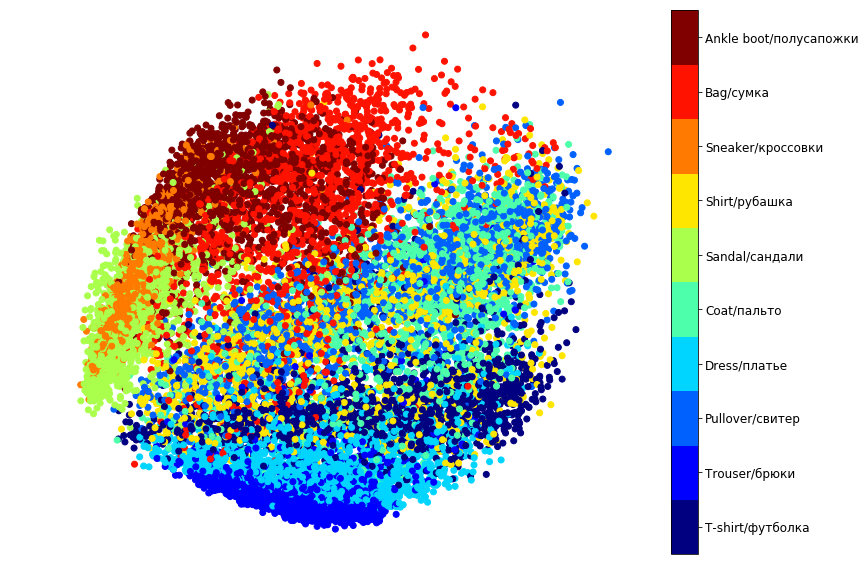

In [0]:

from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X_test)
t1 = time.time()
print("PCA took {:.1f}s.".format(t1 - t0))
#plot_clothes(X_pca_reduced, y)
plt.figure(figsize=(13,10))
plt.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 1], c=y_test, cmap="jet")
plt.axis('off')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.show()

Довольно быстро, но несмотря на то что мы можем выделить несколько кластеров,у нас слишком много взаимных пересечений. Попробуем LLE.

LLE took 483.3s.


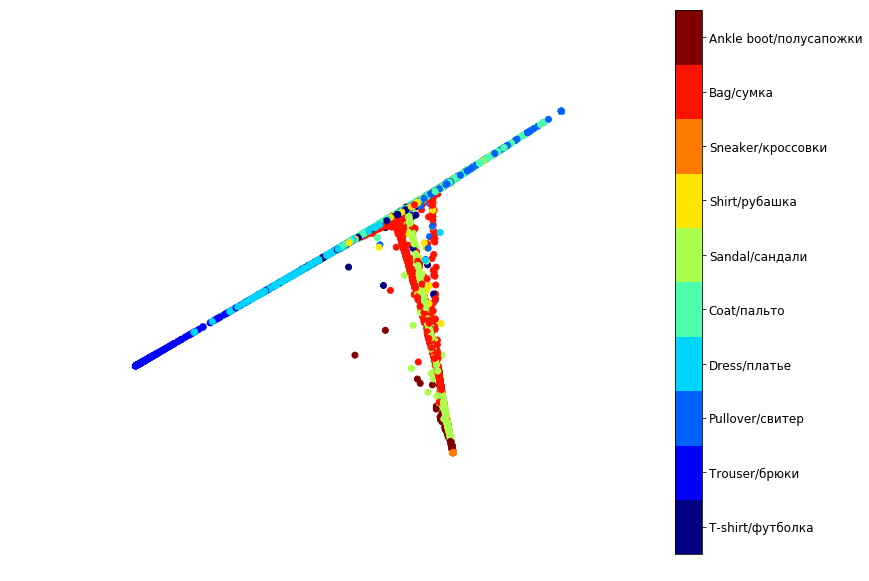

In [0]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X_test)
t1 = time.time()
print("LLE took {:.1f}s.".format(t1 - t0))
plt.figure(figsize=(13,10))
plt.scatter(X_lle_reduced[:, 0], X_lle_reduced[:, 1], c=y_test, cmap="jet")
plt.axis('off')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.show()

Целых 8 минут, а понимания больше не стало. Попробуем скомбинировать PCA и LLE.

PCA+LLE took 43.3s.


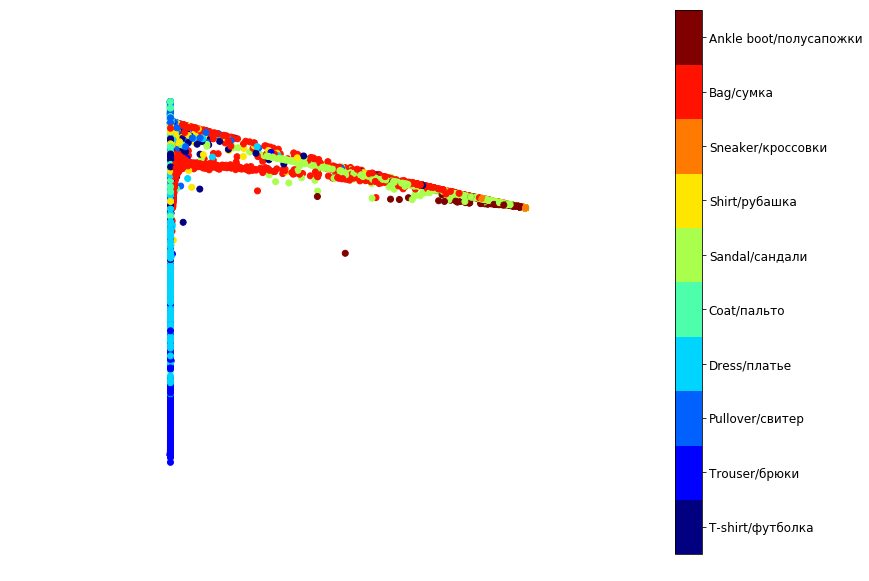

In [0]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X_test)
t1 = time.time()
print("PCA+LLE took {:.1f}s.".format(t1 - t0))
plt.figure(figsize=(13,10))
plt.scatter(X_pca_lle_reduced[:, 0], X_pca_lle_reduced[:, 1], c=y_test, cmap="jet")
plt.axis('off')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.show()

Результат примерно такой же, но скорость в 10 раз больше).

Запустим MDS.Для ускорения работы сделаем подбырку в 2000 элементов:

MDS took 160.0s (on just 2,000 MNIST images instead of 10,000).


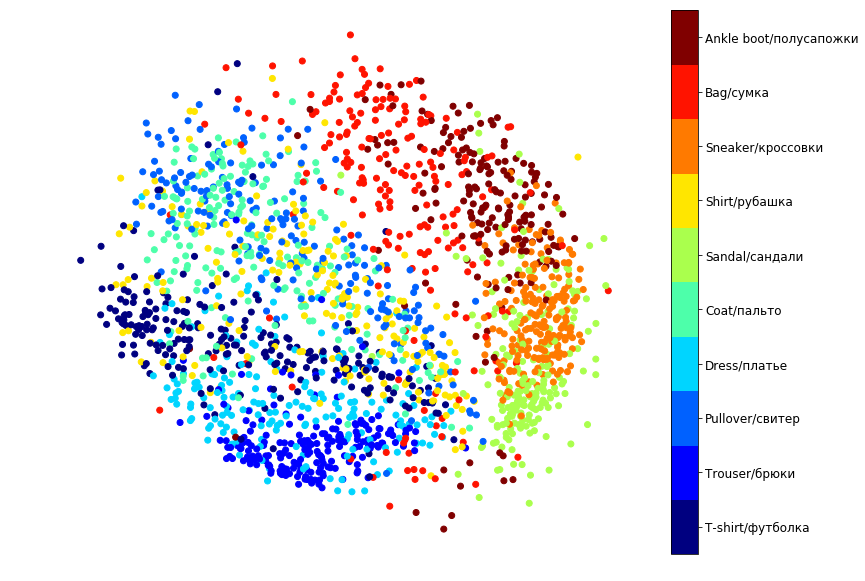

In [0]:
from sklearn.manifold import MDS

m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X_test[:m])
t1 = time.time()
print("MDS took {:.1f}s (on just 2,000 MNIST images instead of 10,000).".format(t1 - t0))
plt.figure(figsize=(13,10))
plt.scatter(X_mds_reduced[:, 0], X_mds_reduced[:, 1], c=y_test[:m], cmap="jet")
plt.axis('off')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.show()

Опять вроде бы и кластеры есть,но слишком много пересечений.

Попробуем опять скомбинировать PCA и МDS

PCA+MDS took 161.9s (on 2,000 MNIST images).


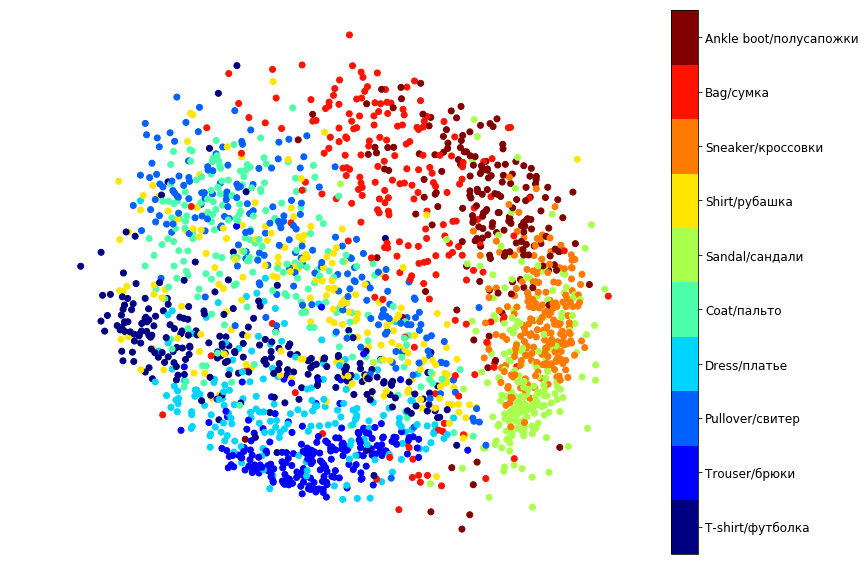

In [0]:

from sklearn.pipeline import Pipeline

pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X_test[:2000])
t1 = time.time()
print("PCA+MDS took {:.1f}s (on 2,000 MNIST images).".format(t1 - t0))
plt.figure(figsize=(13,10))
plt.scatter(X_pca_mds_reduced[:, 0], X_pca_mds_reduced[:, 1], c=y_test[:2000], cmap="jet")
plt.axis('off')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.show()

Тоже самое что по времени, что по результату.

Попробуем зайти с LDA

LDA took 2.6s.


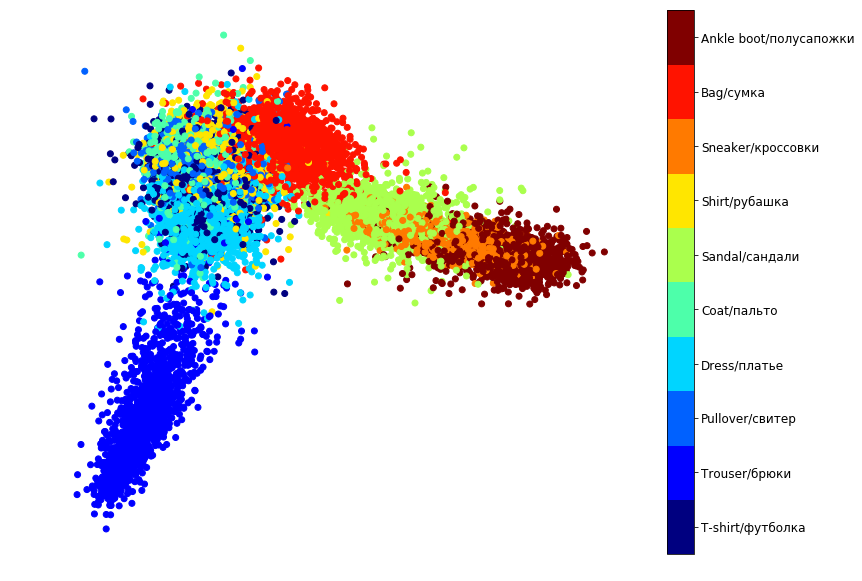

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X_test, y_test)
t1 = time.time()
print("LDA took {:.1f}s.".format(t1 - t0))
plt.figure(figsize=(13,10))
plt.scatter(X_lda_reduced[:, 0], X_lda_reduced[:, 1], c=y_test, cmap="jet")
plt.axis('off')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.show()

И быстро и даже выглядит как то осмыслено,но только до того момента когда начинаешь понимать что некоторые кластеры пересекаются с несколькоми одновремено, что полностью убивает смысл.

Пока все идет к тому как и предсказывалось-TSNE выигрывает у остальных методов:

t-SNE took 718.0s.


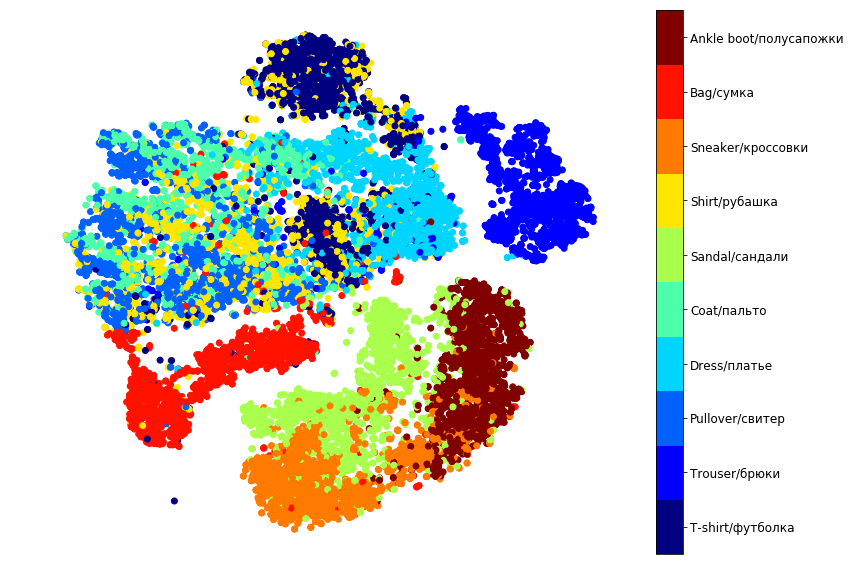

In [0]:
from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X_test)
t1 = time.time()
print("t-SNE took {:.1f}s.".format(t1 - t0))
plt.figure(figsize=(13,10))
plt.scatter(X_tsne_reduced[:, 0], X_tsne_reduced[:, 1], c=y_test, cmap="jet")
plt.axis('off')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.show()

PCA+t-SNE took 249.7s.


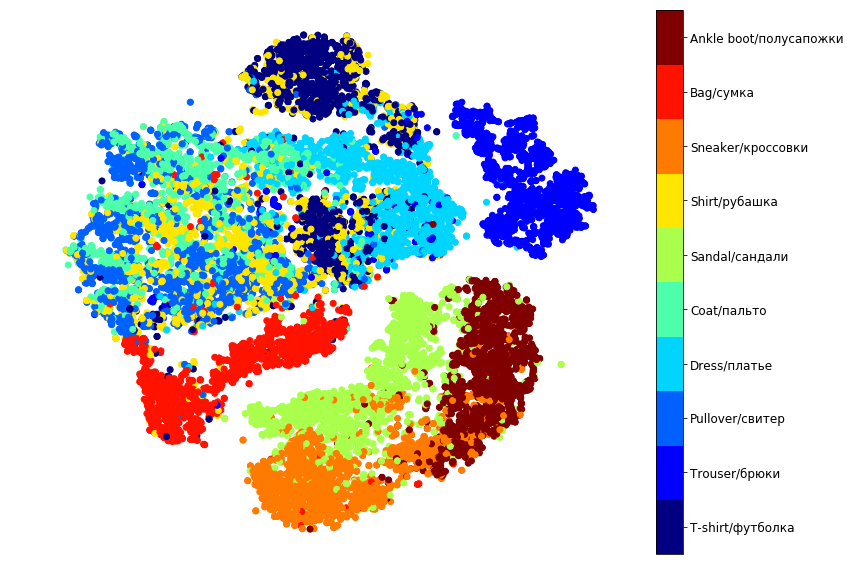

In [0]:

pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X_test)
t1 = time.time()
print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))
plt.figure(figsize=(13,10))
plt.scatter(X_pca_tsne_reduced[:, 0], X_pca_tsne_reduced[:, 1], c=y_test, cmap="jet")
plt.axis('off')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.show()


Вот это поворот мы почти в 3 раза увеличили скорость, без особого вреда для полученной структуры.
1. По факту у нас остались все те же плюсы и минусы с глобальной и локальной структурой данных
2. Можно предположить что использование PCA  для "предобработки" вкупе с TSNE неплохая идея для совмещения алгоритмов

### Глава 4.Umap для Fasnion MNIST

In [0]:
%%time
embedding = umap.UMAP(n_neighbors=5).fit_transform(data)

D:\anaconda\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


Wall time: 1min 16s


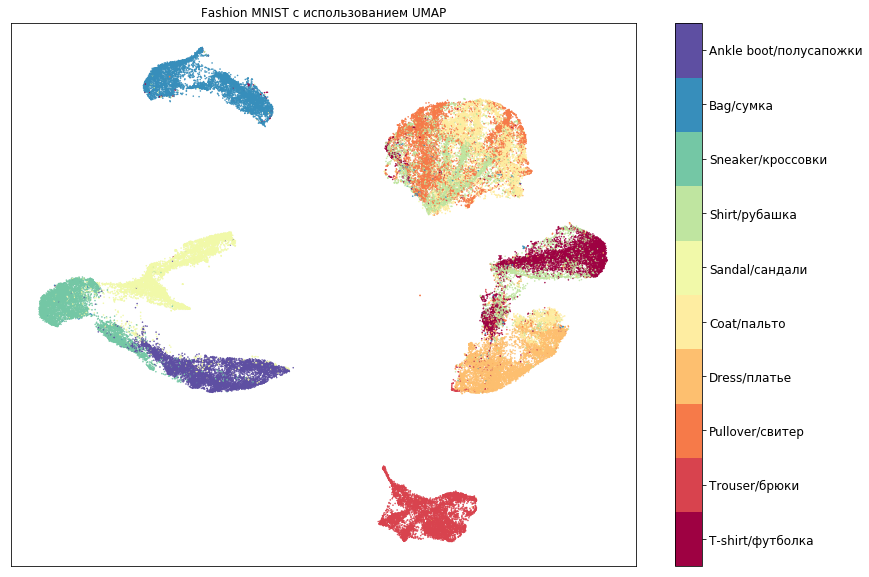

In [0]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST с использованием UMAP');

Очень приличный результат. Нам удалось разделисть между собой классы и получить представление об общей структуре данных. Однако, есть несколько классов, которые не сепарированы не так хорошо. В частности, футболки, рубашки, платья, пуловеры и пальто все в одной куче. Хотя бы платья выделены неплохо а футболки в основном находятся в одном большом скоплении, но они не очень хорошо отличаются от других. Самая плохая ситуация с пальто, рубашками и пуловерами (что неудивительно, поскольку они реально очень похожи). Загоним пожалуй в umap информацию об лейблах

In [0]:
%%time
embedding = umap.UMAP().fit_transform(data, y=target)

D:\anaconda\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


Wall time: 2min 1s


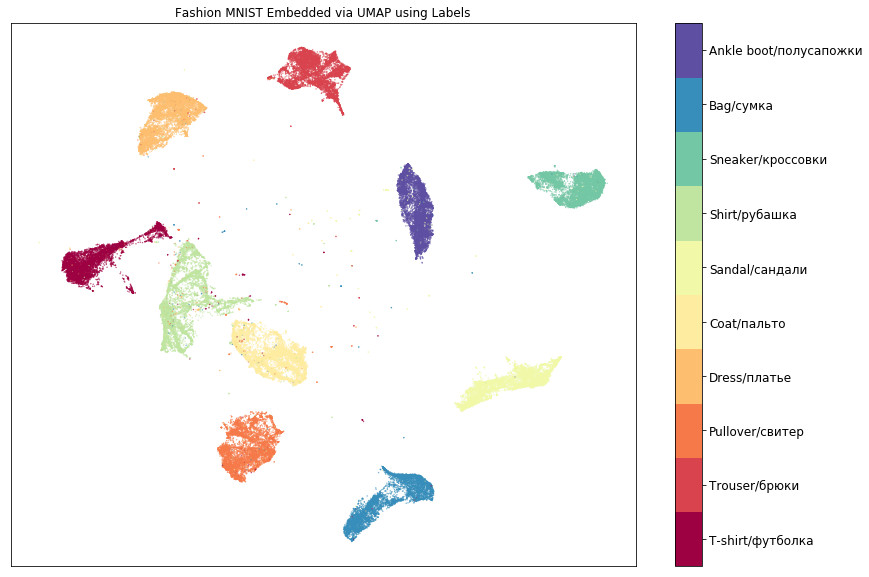

In [0]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.1, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST с использованием UMAP + метки');

В результате получается четко разделенный набор классов (и немного случайных шумовых точек, которые достаточно отличались от своего класса, чтобы не быть сгруппированными с остальными). Однако, помимо четкого разделения классов (неудивительно ведь мы скормили алгоритму данные о метках), отметим следующее. 
1. Сохранена внутреняя структура отдельных классов. Как сапожки, так и сумки по-прежнему имеют четкий рисунок полосы, который был виден в оригинальном бесконтрольном случае; брюки, футболки и сумки сохранили свою форму и внутреннюю структуру. 
2. Во-вторых, мы также сохранили глобальную структуру. В то время как отдельные классы были четко отделены друг от друга, взаимоотношения между классами были сохранены: классы обуви находятся рядом друг с другом; брюки и сумки находятся на противоположных сторонах участка; и дуга пуловеров, рубашек, футболок и платьев все еще на месте.


In [0]:
masked_target = target.copy().astype(np.int8)
masked_target[np.random.choice(70000, size=10000, replace=False)] = -1

In [0]:
%%time
fitter = umap.UMAP().fit(data, y=masked_target)
embedding = fitter.embedding_

Wall time: 1min 49s


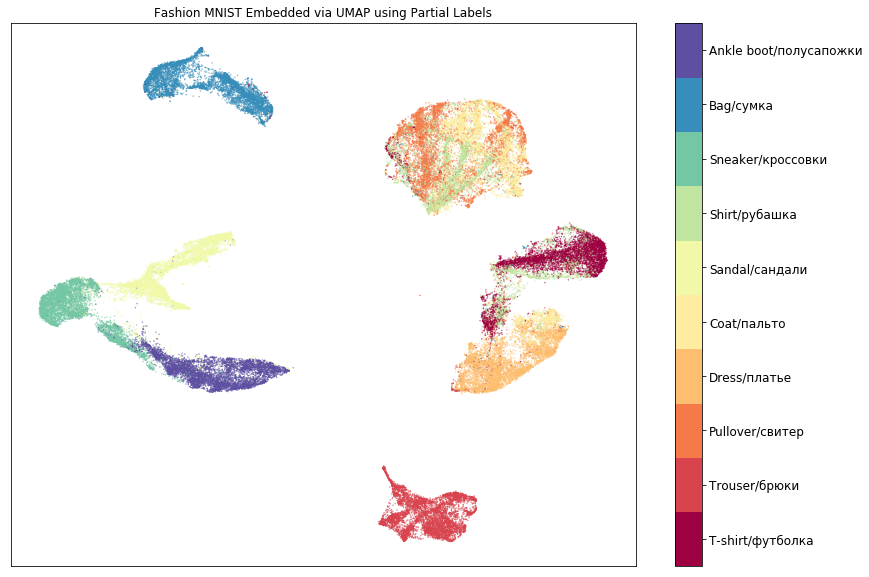

In [0]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.1, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP using Partial Labels');

Сделали обучение с подкреплением. 
Впринципе все так как и ожидалось,по сравненению с полностью контролируемым обучением результат хуже(есть наложение кластеров), но в целом с локальная и глобльная структура сохранены . 

In [0]:
train_data = np.array(X_train)
test_data = np.array(X_test)

In [0]:
%%time
mapper = umap.UMAP(n_neighbors=10).fit(train_data, np.array(y_train))

Wall time: 1min 15s


In [0]:
%%time
test_embedding = mapper.transform(test_data)

Wall time: 13.7 s


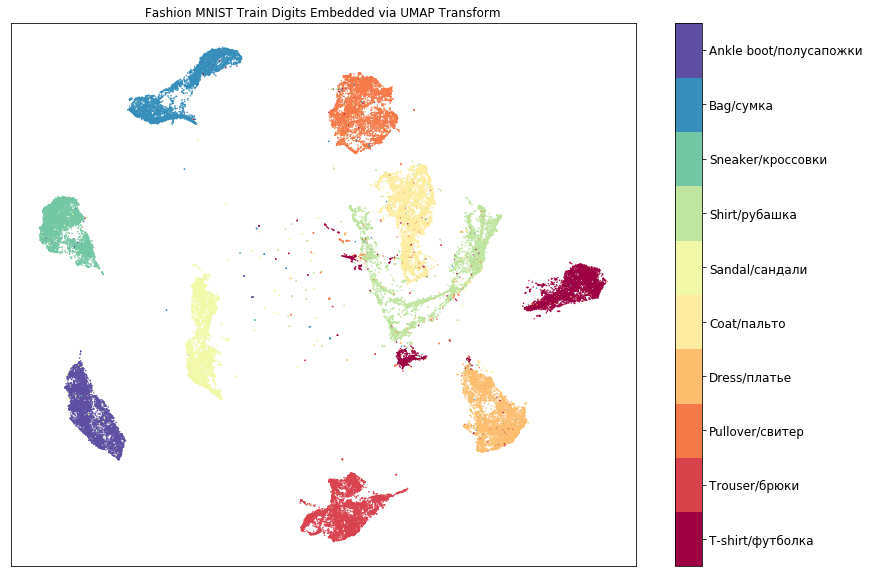

In [0]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*mapper.embedding_.T, s=0.3, c=np.array(y_train), cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Train Digits Embedded via UMAP Transform');

Обучили нашу модель на тренировочном наборе с внедрением меток.Теперь внедрим нашу модель на тестовый набор без участия меток.

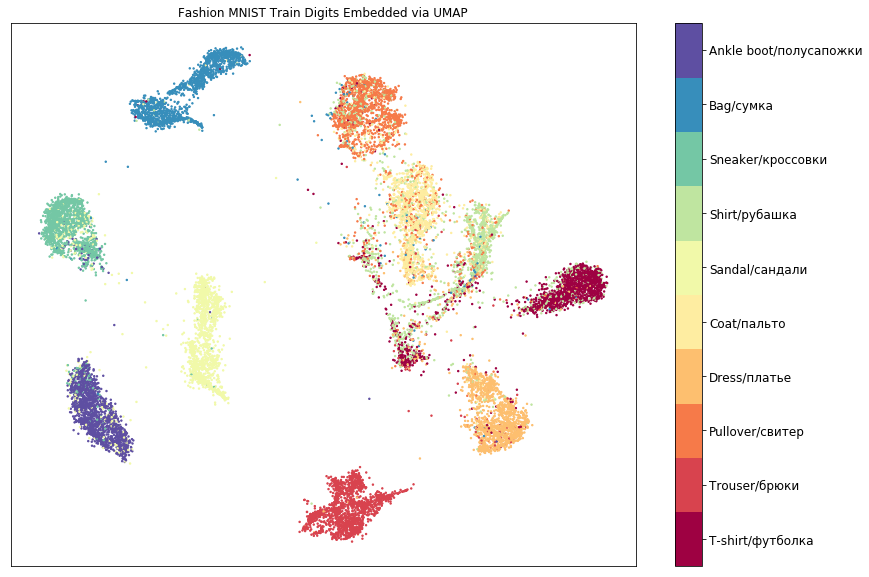

In [0]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*test_embedding.T, s=2, c=np.array(y_test), cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Train Digits Embedded via UMAP');

Считаю неплохой результат). Глобально данные разнесены логично (кросовки от футболок,сумки от брюк). Классы разделены и имеют внутреннюю структуры. И все та же единная проблема для всех методом снижения размерности- смешение кластеров верхней одежды.

### Глава 5.Восстановление изображения при помощи PCA.Пример восстановления изображений при выбранном количестве компонент с использованием PCA

In [0]:
pca = PCA()
pca.fit(X_test)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

185

Определяем количество компонент, необходимых для "покрытия" 95 процентов нашего variance_ratio

In [0]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [0]:
np.sum(pca.explained_variance_ratio_)

0.9500203831163387

In [0]:
pca = PCA(n_components = 185)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

Создаем две выборки: "восстановленную" и "обучающую"

In [0]:
def plot_components(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5,1,'Compressed')

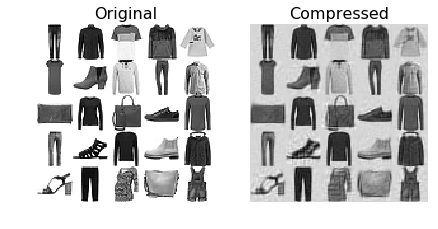

In [0]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_components(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_components(X_recovered[::2100])
plt.title("Compressed", fontsize=16)


Адекватный результат. Впринципе добавить особо нечего